Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
# importa dataset 'lastfm playlists'
data = pd.read_csv("../datasets/Books.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Books'
user_col = 'user_id'

In [4]:
data.shape

(51311621, 4)

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800


### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

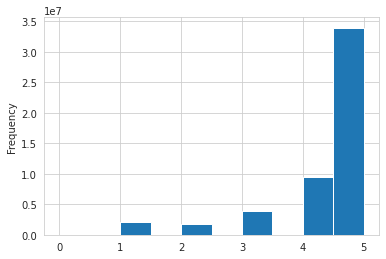

In [6]:
data['rating'].plot(kind='hist')

In [7]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [8]:
pos_ratings

5.0

In [9]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [ ]:
# number of remaining cases
data.shape[0]

### Convert timestamp

In [10]:
%%time
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 53 s, sys: 4.93 s, total: 58 s
Wall time: 57.8 s


In [11]:
data.head()

,user_id,item_id,timestamp,date
3476836,0140125183,A2P9YDRHZTJMC3,833500800,1996-05-31
18394619,0876851898,A3CX6N6BFFV1NS,835315200,1996-06-21
12923138,0553092626,A3RTKL9KB8KLID,840240000,1996-08-17
890264,0045300232,A3RTKL9KB8KLID,843004800,1996-09-18
17596157,0806128887,A1G2W2C669C8GC,848016000,1996-11-15


In [14]:
data.tail()

,user_id,item_id,timestamp,date
51304223,B01G9NVTSI,AHJDHJFLP7CPD,1538265600,2018-09-30
51304951,B01GEXSYXQ,A18RHTVSMBC6SP,1538352000,2018-10-01
51309931,B01HB9Q7CW,A2UUXH691JARF3,1538352000,2018-10-01
51309500,B01H7ZJRNG,AEC2WVP8H25HF,1538438400,2018-10-02
51307743,B01GW712JW,A2ZXRFUDBCF5KR,1538438400,2018-10-02


In [15]:
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

In [16]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

## Evaluating Time defined Buckets 

Sampling the dataset

In [17]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 20.8 s, sys: 684 ms, total: 21.5 s
Wall time: 21.4 s


<AxesSubplot:xlabel='date'>

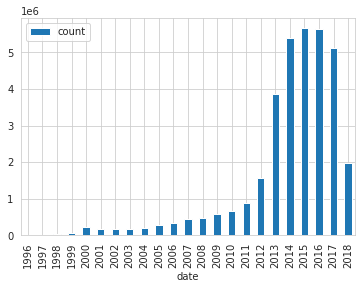

In [18]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [53]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
y_filter = (data['date'] < datetime.strptime('2015', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 

In [54]:
y_filter.sum()

3751848

In [55]:
data = data[y_filter]

In [56]:
# number of remaining cases
data.shape[0]

3751848

Sampling the dataset - only most frequent users (overall)

In [57]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 937 ms, sys: 4.02 ms, total: 941 ms
Wall time: 936 ms


<AxesSubplot:ylabel='Frequency'>

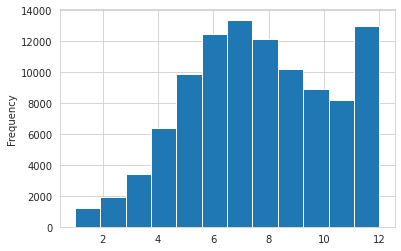

In [58]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [59]:
# we'll filter users with frequency higher than q
threshold = np.quantile(user_freq_over_months, q=0.5)
threshold

8.0

In [60]:
# there are this many users with freq above the threshold
(user_freq_over_months >= threshold).sum()

52474

In [61]:
# index of frequent users
freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [62]:
data = data.set_index('user_id').loc[freq_users].reset_index()

In [63]:
# number of remaining cases
data.shape[0]

2915770

How many interactions occur in each month / year?

CPU times: user 1.24 s, sys: 12.1 ms, total: 1.25 s
Wall time: 1.25 s


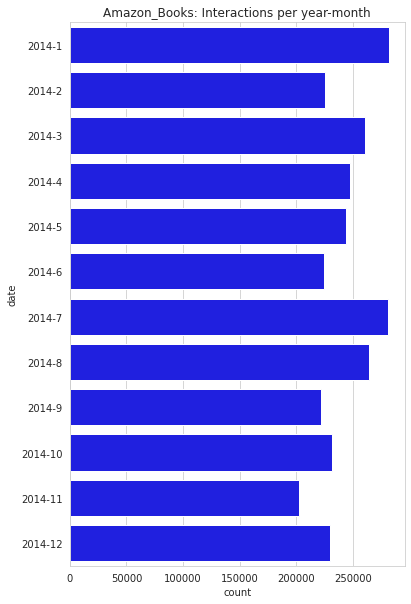

In [64]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [65]:
%%time
#38min 13s
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)

CPU times: user 38min 12s, sys: 411 ms, total: 38min 13s
Wall time: 38min 13s


In [66]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
0,000100039X,1.0,1.0,1.0
1,0316544965,1.0,1.0,1.0
2,0316743305,1.0,1.0,1.0
3,0316614564,1.0,1.0,1.0
4,0307291650,1.0,1.0,1.0


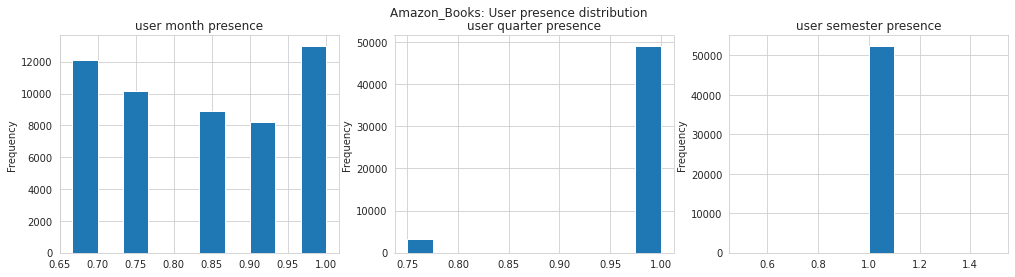

In [67]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

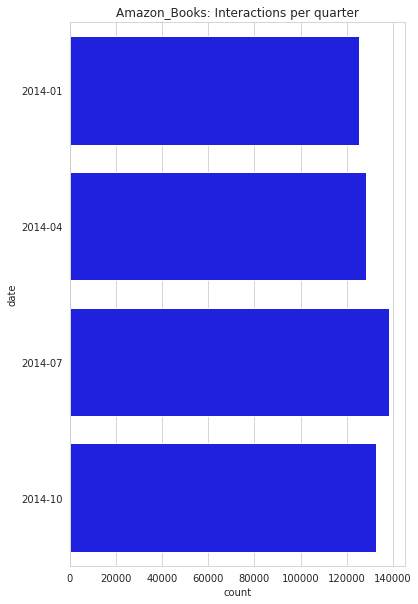

In [68]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

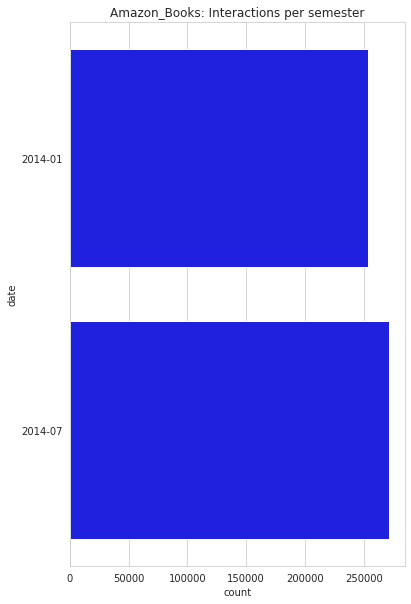

In [69]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [70]:
# defining threshold
frequency_threshold = 0.8

In [71]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

30146 users of 52474 (57.449%) occurr in 80.0% or more months.
49112 users of 52474 (93.593%) occurr in 80.0% or more quarters.
52474 users of 52474 (100.0%) occurr in 80.0% or more semesters.


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [72]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# freq_user_quarter_info

<AxesSubplot:>

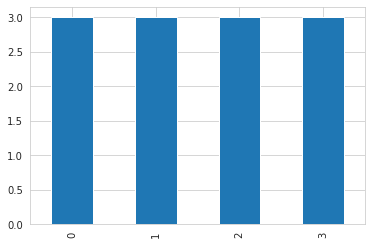

In [73]:
freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

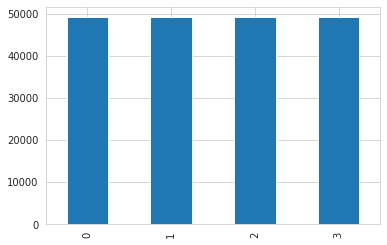

In [74]:
freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [202]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [75]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# freq_user_semester_info

<AxesSubplot:>

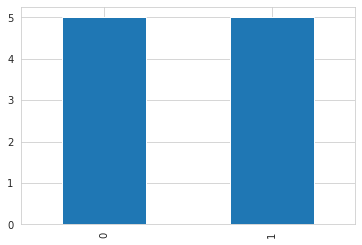

In [76]:
freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

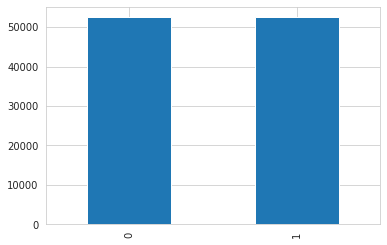

In [77]:
freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [78]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [79]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [80]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

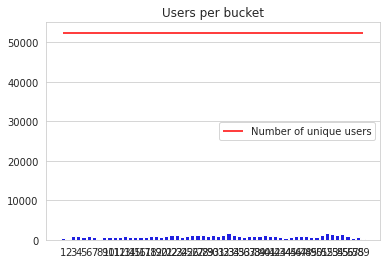

In [81]:
plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [83]:
%%time
# 2h 52min 2s
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

CPU times: user 2h 52min 1s, sys: 1.53 s, total: 2h 52min 2s
Wall time: 2h 52min 2s


In [84]:
frequency_threshold = 0.8

In [85]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

0 users of 52474 (0.0%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [86]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

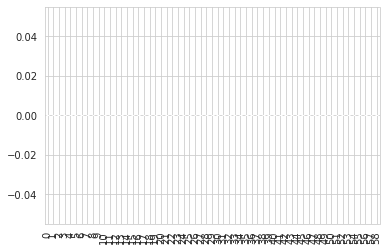

In [87]:
freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

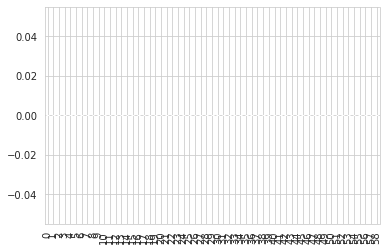

In [88]:
freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

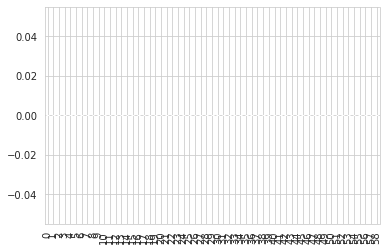

In [89]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

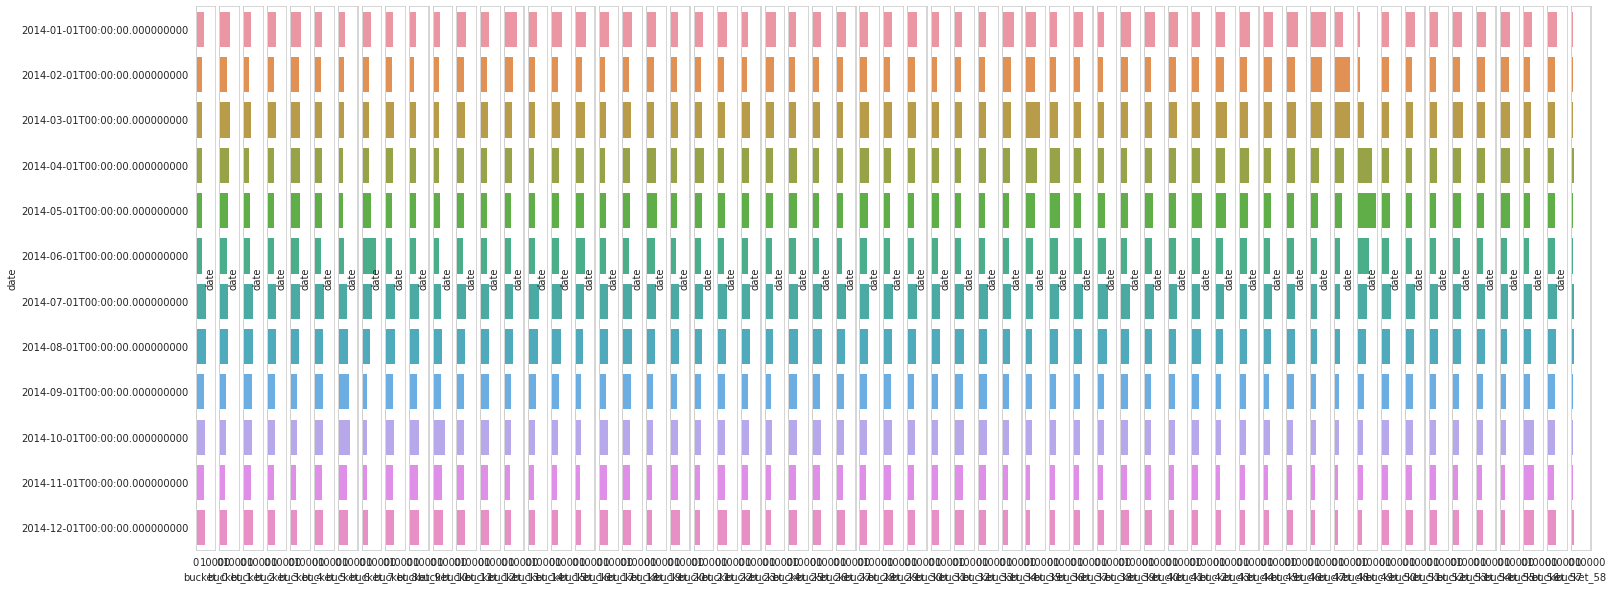

In [90]:
plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [ ]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
# joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)